### Learned Bloom Filter

A learned bloom filter uses a `learned oracle` as a pre-filtering stage in front of a standard bloom filter, called the back-up bloom filter. The oracle function $f(x)$ represents $Pr[x \in S]$. We set a threshold $\tau$ such that if $f(x) \geq \tau$, we return `True` for the query. Otherwise, if $f(x) < \tau$, we send the query to the back-up bloom filter. The back-up bloom filters job is to eliminate the possibility of getting false negatives. 

Given a set of elements $S$ from universe $U$, we can train the oracle using any ML model on the binary classification task with negative log likelihood loss function. The training dataset contains `(query, label)` pairs, with both positive and negative samples. 

Positive samples are all the elements from $S$ and negative samples are all the elements $U\setminus S$.

The back-up bloom filter is only meant to hold the subset of positive keys $\set{x \in S : f(x)<\tau}$ which are mis-classified by the oracle (i.e. False Negatives), instead of all keys in $S$, which can lead to significant space savings compared to a standard bloom filter on entire $S$.

We keep a held-out set of negative samples $Q$ with which we tune the threshold $\tau$, and the backup-bloom filter parameters, to acheive a desired false positive rate $\delta$. (More on this later...)

The goal is to create a 2-stage bloom filter that consumes less space than a standard bloom filter while achieving the same (or better) false positive rate.


In [1]:
import random
import sympy as sp
import math
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np


random.seed(123)

In [2]:
class TwoUniversalHashFamily:
    def __init__(self, m, max_key):
        self.m = m  # Size of the hash table
        self.p = sp.nextprime(max_key)  # generate a large prime number, greater than any key
        self.a = random.randint(1, self.p-1)  # Choose a randomly
        self.b = random.randint(0, self.p-1)  # Choose b randomly

    def hash(self, k):
        return ((self.a * k + self.b) % self.p) % self.m
    
    def __call__(self, k):
        return self.hash(k)


class BloomStandard:
    def __init__(self, S, m, k=None, max_key=10000000):
        self.m = m
        if k is None:
            self.k = max(1,round((m/len(S)) * math.log(2)))  # optimal number of hash functions for a given m and n 
            print(f"Optimal number of hash functions: {self.k}")      
        else:
            self.k = k
        # draw k random hash functions from universal hash family
        self.h = [TwoUniversalHashFamily(m, max_key) for _ in range(self.k)]
        self.B = [0] * self.m

        # construct bit array
        for key in S:
            self.insert(key)
        print(f"Bloom filter constructed! Size: {self.m}, Number of hash functions: {self.k}")

    # insert new integer key into the bloom filter 
    def insert(self, key):
        for i in range(self.k):
            self.B[self.h[i](key)] = 1

    # poerform membership query for the given key
    def query(self, key):
        q = [0]*self.k
        for i in range(self.k):
            q[i] = self.B[self.h[i](key)]
        if 0 in q:
            return False
        else:
            return True    
            
    def __str__(self):
        return str(self.B)

In [16]:
# define pytroch dataset class for training
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, positive_samples, negative_samples):
        if positive_samples is None:
            positive_samples = []
        self.samples = positive_samples + negative_samples
        random.shuffle(self.samples)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        x, y = self.samples[idx]
        # convert to tensor
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(y, dtype=torch.long)
        return x, y


# define neural network with two hidden layers
class Oracle(torch.nn.Module):
    def __init__(self, hidden_dims=10, dropout_rate=0.2):
        super(Oracle, self).__init__()
        self.hidden_dims = hidden_dims
        self.hidden_layer1 = torch.nn.Linear(1, hidden_dims)
        self.hidden_layer2 = torch.nn.Linear(hidden_dims, hidden_dims)
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
        #self.batch_norm = torch.nn.BatchNorm1d(hidden_dims)
        #self.leaky_relu = torch.nn.LeakyReLU(0.01)
        self.output_layer = torch.nn.Linear(hidden_dims, 2)
        self.dropout = torch.nn.Dropout(dropout_rate)    

    def forward(self, x):
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        x = self.relu(x)
        #x = self.tanh(x)
        #x = self.batch_norm(x)
        #x = self.leaky_relu(x)
        #x = self.dropout(x)
        # compute output logits
        x = self.output_layer(x)
        return x
    

# training loop
def train(train_dataloader, model, optimizer, num_epochs=10, device='cpu'):
    model.train()
    for epoch in range(num_epochs):
        pbar = tqdm(train_dataloader, desc="Epochs")
        num_total, num_pos_total, num_neg_total = 0, 0, 0
        num_correct, num_pos_correct, num_neg_correct = 0, 0, 0
        avg_loss = 0
        for batch in pbar:
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            # flatten the labels
            y = y.view(-1)      
            loss = F.cross_entropy(outputs, y)
            loss.backward()
            optimizer.step()

            # compute moving average loss
            avg_loss = 0.9 * avg_loss + 0.1 * loss.item()

            # compute accuracy for batch precictions
            _, predicted = torch.max(outputs, 1)
            num_total += y.shape[0]
            num_correct += (predicted == y).sum().item()
            accuracy = num_correct / num_total

            # compute accuracy for positive samples
            num_pos_total += y[y == 1].shape[0]
            num_pos_correct += (predicted[y == 1] == 1).sum().item()
            pos_accuracy = num_pos_correct / max(1,num_pos_total)

            # compute accuracy for negative samples
            num_neg_total += y[y == 0].shape[0]
            num_neg_correct += (predicted[y == 0] == 0).sum().item()
            neg_accuracy = num_neg_correct / max(1,num_neg_total)  

            pbar.set_description(f"Epoch {epoch + 1}, Train Loss: {avg_loss:.5f}, Train Accuracy Overall: {accuracy: .5f}, Train Accuracy Positive: {pos_accuracy:.5f}, Train Accuracy Negative: {neg_accuracy:.5f}")


# evaluation on test negative samples
def evaluate(test_dataloader, model, tau=0.5, device='cpu'):
    num_total = 0
    num_correct = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            predicted = (outputs[:, 1] >= tau).long()
            num_total += y.shape[0]
            num_correct += (predicted == y).sum().item()
        accuracy = num_correct / num_total
    FP_rate = 1 - accuracy    
    print(f"Test FP rate: {FP_rate:.5f}")
    return FP_rate

Let's start with a simple dataset. Suppose the universe is $U = \set{0,1,2... 50000-1}$ and $S = \set{1000,1001,...,2000-1}$, i.e. the positive keys are all the integers in the range[1000,1999]. Then the target oracle function needs to be: 
$$
f(x) = 
\begin{cases} 
1 & \text{if } 1000 \leq x < 2000 \\
0 & \text{otherwise}
\end{cases}
$$

We will now try to learn this target function with a neural network with 1 hidden layer trained on binary classification task.

In [213]:
n_test = 5000
usize = 50000

# prepare training dataset
positive_samples_train = [(x,1) for x in range(1000,2000)]
all_negative_samples = [(x,0) for x in (list(range(0,1000)) + list(range(2000,usize)))]
# draw n_test negative samples for testing
negative_samples_test = random.sample(all_negative_samples, n_test)
# prepare training negative samples by removing n_test samples from all_negative_samples
negative_samples_train = [x for x in all_negative_samples if x not in negative_samples_test]

In [214]:
# model hyperparameters
batch_size = 256
hidden_dims = 50
num_epochs = 10
device = 'cuda'

# define model and optimizer
model = Oracle(hidden_dims).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# prepare training dataloader
train_dataset = BloomDataset(positive_samples_train, negative_samples_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = BloomDataset(None, negative_samples_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [215]:
# train the model
train(train_dataloader, model, optimizer, num_epochs=250, device=device)

Epoch 1, Train Loss: 0.97151, Train Accuracy Overall:  0.46738, Train Accuracy Positive: 0.54800, Train Accuracy Negative: 0.46555: 100%|██████████| 176/176 [00:01<00:00, 146.76it/s]  
Epoch 2, Train Loss: 1.03498, Train Accuracy Overall:  0.97778, Train Accuracy Positive: 0.00000, Train Accuracy Negative: 1.00000: 100%|██████████| 176/176 [00:01<00:00, 133.62it/s]
Epoch 3, Train Loss: 0.81445, Train Accuracy Overall:  0.97778, Train Accuracy Positive: 0.00000, Train Accuracy Negative: 1.00000: 100%|██████████| 176/176 [00:01<00:00, 147.89it/s]
Epoch 4, Train Loss: 0.79866, Train Accuracy Overall:  0.97778, Train Accuracy Positive: 0.00000, Train Accuracy Negative: 1.00000: 100%|██████████| 176/176 [00:01<00:00, 145.58it/s]
Epoch 5, Train Loss: 0.73885, Train Accuracy Overall:  0.97778, Train Accuracy Positive: 0.00000, Train Accuracy Negative: 1.00000: 100%|██████████| 176/176 [00:01<00:00, 148.86it/s]
Epoch 6, Train Loss: 0.54888, Train Accuracy Overall:  0.97778, Train Accuracy Posi

In [216]:
# compute model predictions for all universe items
universe = list(range(0,usize))
predictions = []
model.eval()
with torch.no_grad():
   for i in range(0, usize, batch_size):
        x = torch.tensor(universe[i:i+batch_size], dtype=torch.float32).unsqueeze(1).to(device)
        outputs = model(x)
        # apply softmax to get class probabilities
        predicted = torch.nn.Softmax(dim=1)(outputs)
        predictions.extend(predicted[:,1].cpu().numpy())

Test FP rate: 0.00000


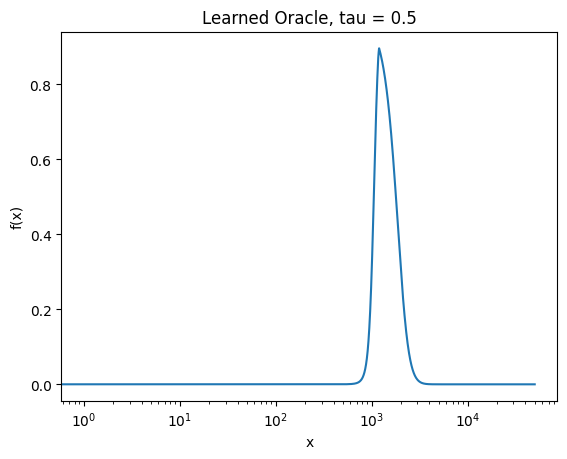

In [219]:
tau = 0.5

x = universe
f = [1 if p > tau else 0 for p in predictions] 

f_neg_test = [f[x] for x,_ in negative_samples_test]
FP_rate = sum(f_neg_test) / len(f_neg_test)
print(f"Test FP rate: {FP_rate:.5f}")

f = predictions

# plot the model predictions
plt.plot(x, f)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Learned Oracle, tau = '+ str(tau))
plt.xscale('log')


The learned oracle exactly reconstructs the target oracle with $\tau=0.5$. Not surprising as the target oracle has a very simple functional form and is therefore too easy to approximate.

We will now use a slightly more complex dataset with universe $U = \set{0,1,2... 50000-1}$ and $S$ containing 500 integers randomly sampled from the range $[1000,2000]$ and another 500 sampled from outside this range. Then the target oracle function needs to be: 

The learned oracle will most likely be nearly the same function we learned for the previous simpler dataset which is uniformly 1 in the range $[1000,2000]$ and uniformly 0 outside. Since half the positive samples are outside of the range, we will see the False Positive rate will be more sensitive to the distribution of the test set. e.g. if most of the test negative samples are inside the range, then we will get a high FP rate, and if most of the test negative samples are outside of the range, we will likely get a much small FP rate.

In [111]:
n_test = 1000
usize = 50000

# prepare training dataset
x_all = list(range(0,usize))
x_range = list(range(1000,2000))

# draw 500 positive samples from inside range and 500 from outside
positive_x = random.sample(x_range, 500) + random.sample(x_all, 500)
negative_x = [x for x in x_all if x not in positive_x]
positive_samples_train = [(x,1) for x in positive_x]

# draw n_test negative samples with large proportion from range
negative_x_test = [x for x in x_range if x not in positive_x] 
negative_x_test = negative_x_test + random.sample(negative_x, n_test - len(negative_x_test))
negative_samples_test = [(x,0) for x in negative_x_test]

# prepare training negative samples
negative_samples_train = [(x,0) for x in negative_x if x not in negative_x_test]

In [145]:
# model hyperparameters
batch_size = 512
hidden_dims = 1000
num_epochs = 10

# define model and optimizer
model = Oracle(hidden_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# prepare training dataloader
train_dataset = BloomDataset(positive_samples_train, negative_samples_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = BloomDataset(None, negative_samples_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [147]:
# train the model
train(train_dataloader, model, optimizer, num_epochs=100)

Epoch 1, Train Loss: 20.69221, Train Accuracy Overall:  0.96990, Train Accuracy Positive: 0.01300, Train Accuracy Negative: 0.98984: 100%|██████████| 96/96 [00:00<00:00, 114.75it/s]
Epoch 2, Train Loss: 34.66589, Train Accuracy Overall:  0.96664, Train Accuracy Positive: 0.02300, Train Accuracy Negative: 0.98629: 100%|██████████| 96/96 [00:00<00:00, 117.46it/s]
Epoch 3, Train Loss: 51.77120, Train Accuracy Overall:  0.97041, Train Accuracy Positive: 0.01300, Train Accuracy Negative: 0.99036: 100%|██████████| 96/96 [00:00<00:00, 115.58it/s]
Epoch 4, Train Loss: 25.99043, Train Accuracy Overall:  0.97080, Train Accuracy Positive: 0.01000, Train Accuracy Negative: 0.99081: 100%|██████████| 96/96 [00:00<00:00, 105.91it/s]
Epoch 5, Train Loss: 12.57719, Train Accuracy Overall:  0.96803, Train Accuracy Positive: 0.01300, Train Accuracy Negative: 0.98792: 100%|██████████| 96/96 [00:00<00:00, 116.08it/s]
Epoch 6, Train Loss: 1.17048, Train Accuracy Overall:  0.97139, Train Accuracy Positive: 0

In [176]:
# evaluate the model
evaluate(test_dataloader, model, tau=0.5)

# compute model predictions for all universe items
universe = list(range(0,usize))
predictions = []
model.eval()
with torch.no_grad():
    for x in universe:
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        outputs = model(x)
        # apply softmax to get class probabilities
        predicted = torch.nn.Softmax(dim=0)(outputs)
        #print(f"x: {int(x.item())}, Probs: {predicted.tolist()}")
        predictions.append(predicted[1].item())

Test FP rate: 0.00000


In [177]:
"""
tau = 1e-8
model.eval()
with torch.no_grad():
    for x,_ in negative_samples_test[500:600]:
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        outputs = model(x)
        # apply softmax to get class probabilities
        predicted = torch.nn.Softmax(dim=0)(outputs)
        print(f"x: {int(x.item())}, Probs: {predicted.tolist()}, Prediction: {predicted[1].item() > tau}")
"""

'tau = 1e-8\nmodel.eval()\nwith torch.no_grad():\n    for x,_ in negative_samples_test[500:600]:\n        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)\n        outputs = model(x)\n        # apply softmax to get class probabilities\n        predicted = torch.nn.Softmax(dim=0)(outputs)\n        print(f"x: {int(x.item())}, Probs: {predicted.tolist()}, Prediction: {predicted[1].item() > tau}")'

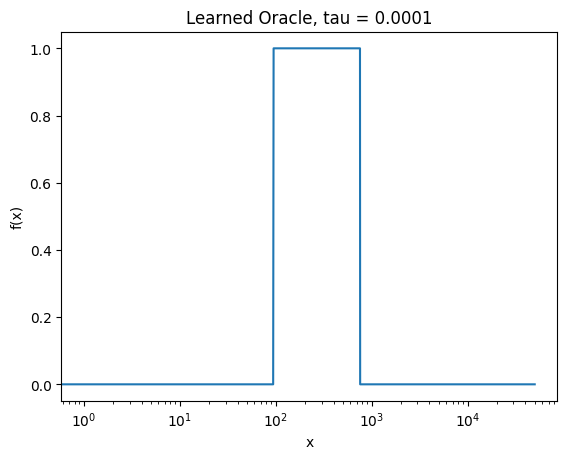

In [179]:
tau = 1e-4

x = universe
f = [1 if p > tau else 0 for p in predictions] 

# plot the model predictions
plt.plot(x, f)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Learned Oracle, tau = '+ str(tau))
plt.xscale('log')

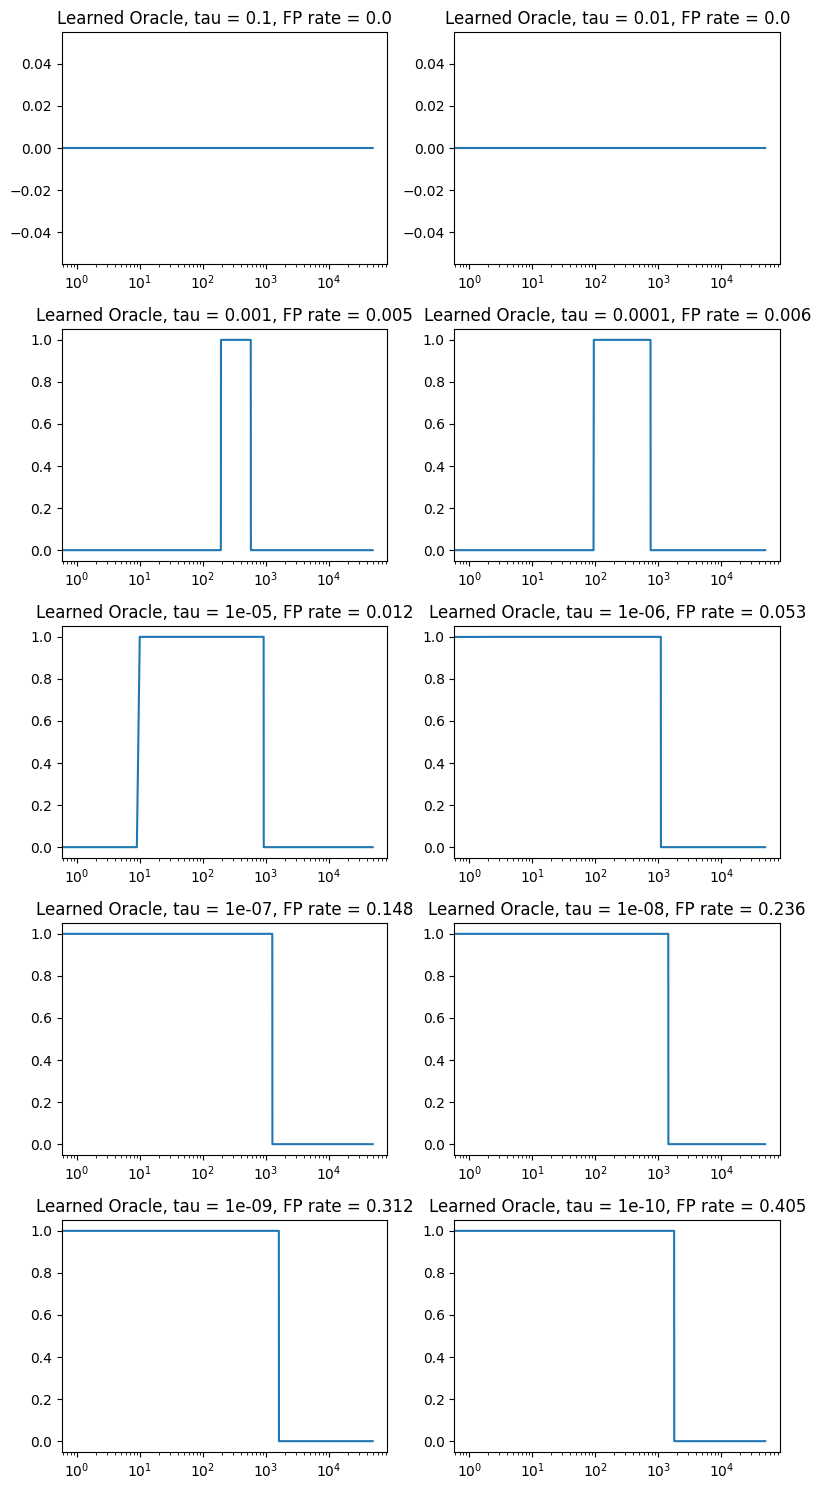

In [185]:
tau_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

fig, axs = plt.subplots(5, 2, figsize=(8, 15))
for i, tau in enumerate(tau_values):
    f = [1 if p > tau else 0 for p in predictions]
    f_neg_test = [f[x] for x in negative_x_test]
    FP_rate = sum(f_neg_test) / len(f_neg_test)
    # Convert flat index i to a tuple of (row, col) for indexing axs
    row, col = divmod(i, 2)
    axs[row, col].plot(x, f)
    axs[row, col].set_title('Learned Oracle, tau = ' + str(tau) + ', FP rate = '+str(FP_rate))
    axs[row, col].set_xscale('log')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots

For larger $\tau$ values, we just get the trivial learned oracle $f(x) = 0$ which is a constant function that always returns False and therefore will resort to the back-up filter. Not very useful..

Now let's try a dataset where keys are more densely distributed inside two disjoint ranges [1000,2000] and [10000,11000].

In [243]:
n_test = 1000
usize = 20000

# prepare training dataset
x_all = list(range(0,usize))
x_range_1 = list(range(1000,2000))
#x_range_2 = list(range(10000,12000))
#x_out_range = list(range(0,1000)) + list(range(1600,10000)) + list(range(10600,usize))

# draw 400 positive samples from inside each range and 200 from outside
#positive_x = random.sample(x_range_1, 500) + random.sample(x_range_2, 500)  #+ random.sample(x_out_range, 100)
positive_x = x_range_1 #+ x_range_2
positive_samples_train = [(x,1) for x in positive_x]

# draw n_test negative samples uniformly from the universe
negative_x = [x for x in x_all if x not in positive_x]
negative_x_test = random.sample(negative_x, n_test)
negative_samples_test = [(x,0) for x in negative_x_test]

# prepare training negative samples
negative_samples_train = [(x,0) for x in negative_x if x not in negative_x_test]

In [254]:
n_test = 1000
usize = 40000

# prepare training dataset
x_all = list(range(0,usize))
x_range_1 =  list(range(1000,2000)) #list(range(10000,11000))
#x_range_2 = list(range(10000,12000))
#x_out_range = list(range(0,1000)) + list(range(1600,10000)) + list(range(10600,usize))

# normalize the input
x_all = [x/usize for x in x_all]
x_range_1 = [x/usize for x in x_range_1]

# draw 400 positive samples from inside each range and 200 from outside
#positive_x = random.sample(x_range_1, 500) + random.sample(x_range_2, 500)  #+ random.sample(x_out_range, 100)
positive_x = x_range_1 #+ x_range_2
positive_samples_train = [(x,1) for x in positive_x]

negative_x = [x for x in x_all if x not in positive_x]
negative_x_test = random.sample(negative_x, n_test)
negative_samples_test = [(x,0) for x in negative_x_test]

# prepare training negative samples
negative_samples_train = [(x,0) for x in negative_x if x not in negative_x_test]


In [5]:
class PiecewiseConstantDataset(Dataset):
    def __init__(self, usize=20000, a=1000, b=2000):
        self.x = np.arange(0, usize).reshape(-1, 1)
        self.y = np.zeros(shape=(usize)).reshape(-1, 1)
        #self.y[(self.x >= 1000) & (self.x <= 2000)] = 1
        self.y[(self.x >= a) & (self.x <= b)] = 1

        # normalize the input
        #self.x = self.x / usize

        # Standardize input data to have mean 0 and variance 1
        self.x_norm = (self.x - np.mean(self.x)) / np.std(self.x)

    def __len__(self):
        return len(self.x_norm)

    def __getitem__(self, idx):
        return torch.tensor(self.x_norm[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

In [25]:
# model hyperparameters
batch_size = 1024
hidden_dims = 16
device = 'cuda'

# define model and optimizer
model = Oracle(hidden_dims).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# prepare training dataloader
#train_dataset = BloomDataset(positive_samples_train, negative_samples_train)
#train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
#test_dataset = BloomDataset(None, negative_samples_test)
#test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_dataset = PiecewiseConstantDataset(usize=20000, a=17000, b=18000)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


In [29]:
train(train_dataloader, model, optimizer, num_epochs=200, device=device)

Epoch 1, Train Loss: 0.10321, Train Accuracy Overall:  0.94995, Train Accuracy Positive: 0.00000, Train Accuracy Negative: 1.00000: 100%|██████████| 20/20 [00:00<00:00, 85.05it/s]
Epoch 2, Train Loss: 0.10403, Train Accuracy Overall:  0.94995, Train Accuracy Positive: 0.00000, Train Accuracy Negative: 1.00000: 100%|██████████| 20/20 [00:00<00:00, 61.53it/s]
Epoch 3, Train Loss: 0.09976, Train Accuracy Overall:  0.94995, Train Accuracy Positive: 0.00000, Train Accuracy Negative: 1.00000: 100%|██████████| 20/20 [00:00<00:00, 105.23it/s]
Epoch 4, Train Loss: 0.10214, Train Accuracy Overall:  0.94995, Train Accuracy Positive: 0.00000, Train Accuracy Negative: 1.00000: 100%|██████████| 20/20 [00:00<00:00, 101.91it/s]
Epoch 5, Train Loss: 0.09943, Train Accuracy Overall:  0.94995, Train Accuracy Positive: 0.00000, Train Accuracy Negative: 1.00000: 100%|██████████| 20/20 [00:00<00:00, 61.96it/s]
Epoch 6, Train Loss: 0.10045, Train Accuracy Overall:  0.94995, Train Accuracy Positive: 0.00000, 

In [30]:
# compute model predictions for all universe items
universe = train_dataset.x_norm[:,0]
predictions = []
model.eval()
with torch.no_grad():
    # compute in batches
    for i in range(0, len(universe), batch_size):
        x = torch.tensor(universe[i:i+batch_size], dtype=torch.float32).unsqueeze(1).to(device)
        outputs = model(x)
        # apply softmax to get class probabilities
        predicted = torch.nn.Softmax(dim=1)(outputs)
        predictions.extend(predicted[:,1].cpu().numpy())

Text(0.5, 1.0, 'Learned Oracle, tau = 0.25')

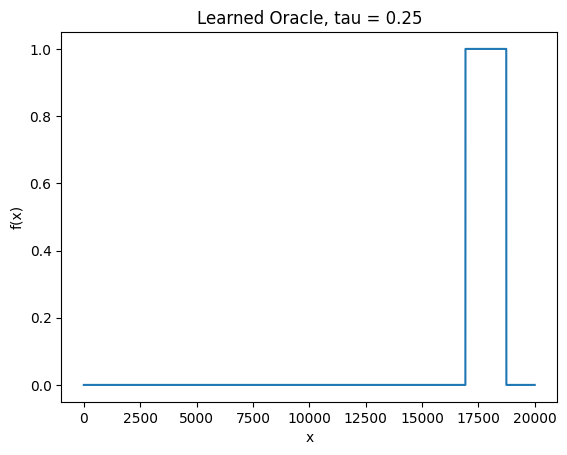

In [32]:
tau = 0.25

x = train_dataset.x[:,0]
#f = [1 if p > tau else 0 for p in predictions] 
#f_neg_test = [f[x] for x,_ in negative_samples_test]
#FP_rate = sum(f_neg_test) / len(f_neg_test)
#print(f"Test FP rate: {FP_rate:.5f}")

f = predictions 

# plot the model predictions
plt.plot(x, f)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Learned Oracle, tau = '+ str(tau))
#plt.xscale('log')
